# Submission Part-1 Data Processing

# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission, if necessary. Sections that begin with **'Implementation'** in the header indicate where you should begin your implementation for your project. Note that some sections of implementation are optional, and will be marked with **'Optional'** in the header.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---
## Step 0: Load The Data

In [1]:
# import required library
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import tensorflow as tf
import cv2
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.utils import resample

import hashlib
import os
import pickle
import math 
from urllib.request import urlretrieve
from PIL import Image
from tqdm import tqdm
from zipfile import ZipFile

import time
from datetime import timedelta

print('All modules imported.')

All modules imported.


In [2]:
# Load pickled data
import pickle

# TODO: fill this in based on where you saved the training and testing data
training_file = 'train.p'
testing_file = 'test.p'

# open file in read binary mode 'rb'
with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_test, y_test = test['features'], test['labels']    

print("Loading data is done.")


Loading data is done.


---

## Step 1: Dataset Exploration

Visualize the German Traffic Signs Dataset. This is open ended, some suggestions include: plotting traffic signs images, plotting the count of each sign, etc. Be creative!


The pickled data is a dictionary with 4 key/value pairs:

- features -> the images pixel values, (width, height, channels)
- labels -> the label of the traffic sign
- sizes -> the original width and height of the image, (width, height)

- coords -> coordinates of a bounding box around the sign in the image, (x1, y1, x2, y2). Based the original image (not the resized version).

In [3]:
### To start off let's do a basic data summary.

# TODO: number of training examples
n_train = len(X_train)

# TODO: number of testing examples
n_test = len(X_test)

# TODO: what's the shape of an image?
image_shape = X_train[0].shape

# TODO: how many classes are in the dataset
from collections import Counter
n_classes = len(Counter(y_train))

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)


Number of training examples = 39209
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


### Plot histogram to visualize the number of counts for each class of sign

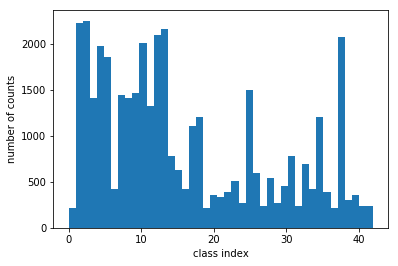

Counter({2: 2250, 1: 2220, 13: 2160, 12: 2100, 38: 2070, 10: 2010, 4: 1980, 5: 1860, 25: 1500, 9: 1470, 7: 1440, 3: 1410, 8: 1410, 11: 1320, 18: 1200, 35: 1200, 17: 1110, 14: 780, 31: 780, 33: 689, 15: 630, 26: 600, 28: 540, 23: 510, 30: 450, 6: 420, 16: 420, 34: 420, 22: 390, 36: 390, 20: 360, 40: 360, 21: 330, 39: 300, 24: 270, 29: 270, 27: 240, 32: 240, 41: 240, 42: 240, 0: 210, 19: 210, 37: 210})


In [4]:
# There are n_classes of traffic signs
plt.hist(y_train, n_classes)
plt.xlabel('class index')
plt.ylabel('number of counts')
plt.show()
# display number of counts for each label 
print(Counter(y_train))

### Visualization 

In [5]:
### Data exploration visualization goes here.
### Feel free to use as many code cells as needed.
# Visualizations will be shown in the notebook.
%matplotlib inline

### Define function to plot imgaes

In [6]:
def plot_images(images, cls_true, cls_pred=None):
    assert len(images) == len(cls_true) == 4
    
    # Create figure with 3x3 sub-plots.
    fig, axes = plt.subplots(2, 2)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)

    for i, ax in enumerate(axes.flat):
        # Plot image.
        if images.shape == (4,32,32,3):
            ax.imshow(images[i])#, cmap='binary')
        if images.shape == (4,32,32):
            ax.imshow(images[i], cmap='binary')
        
        # Show true and predicted classes.
        if cls_pred is None:
            xlabel = "True: {0}".format(cls_true[i])
        else:
            xlabel = "True: {0}, Pred: {1}".format(cls_true[i], cls_pred[i])

        # Show the classes as the label on the x-axis.
        ax.set_xlabel(xlabel)
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

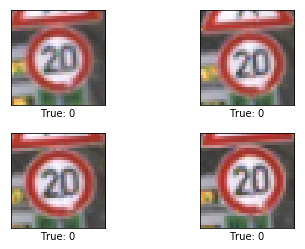

In [7]:
# Get the first images from the train-set.
images = X_train[10:14]

# Get the true classes for those images.
cls_true = y_train[10:14]

# Plot the images and labels using our plot_images function above.
plot_images(images=images, cls_true=cls_true)

---
## Preprocess Data
- Grayscale
- Normalization 
- Shuffle

In [8]:
def convert_rgb_to_gray(dataset):
    gray_img = np.zeros([len(dataset), 32, 32])
    for ind in range(len(dataset)):
        gray_img[ind,] = cv2.cvtColor(dataset[ind,], cv2.COLOR_BGR2GRAY)
    return gray_img

X_train_gray = convert_rgb_to_gray(X_train)
X_test_gray = convert_rgb_to_gray(X_test)

### Normalization

In [9]:
# Normalization for each color image
def normalize_color_image(img):
    img_nor = np.zeros([len(img), 32,32])
    for ind in range(len(img)):
        image = img[ind,]
        img_nor[ind,] = image/255.0
    return img_nor
        
X_train_nor = normalize_color_image(X_train_gray)
X_test_nor = normalize_color_image(X_test_gray)
print("Normalization is done.") 

Normalization is done.


### Shuffle Training Dataset

In [10]:
from sklearn.utils import shuffle

# Rename the training and test dataset as to be more readable.
train_features = X_train_nor
train_labels = y_train

test_features = X_test_nor
test_labels = y_test

# Shuffle training dataset.
train_features, train_labels = shuffle(train_features, train_labels)
print("Random shuffle for train dataset and its corresponding train labels is done.")

Random shuffle for train dataset and its corresponding train labels is done.


### Visualize Shuffled Images And Check Labels
Labels correctly correspond to the assigned images. 

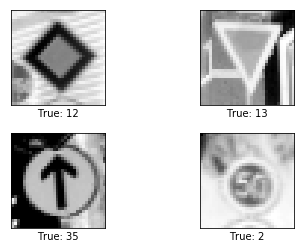

In [11]:
# Get the images from the train-set.
images = train_features[10:14]

# Get the true classes for those images.
cls_true = train_labels[10:14]

# Plot the images and labels using our plot_images function above.
plot_images(images=images, cls_true=cls_true)

## Implementation on pickling dataset
### Summary of the dataset
- **Train and test features were normalized.**
- **Train features and labels were shuffled**

### Save Pickle Data

In [12]:
data = {'train_features': train_features,
        #'valid_features': valid_features,
        'test_features': test_features,
        'train_labels': train_labels,
        #'valid_labels': valid_labels,
        'test_labels': test_labels}

output = open('traffic_sign_preprocess_data.pkl', 'wb')

# Pickle dictionary using protocol 0.
pickle.dump(data, output)

output.close()

print("Pickle data is completed.")

Pickle data is completed.
